![alt text](https://upload.wikimedia.org/wikipedia/commons/2/22/ENSAE_logo_developpe.jpg)

<center>__*** Éléments Logiciels pour le Traitement des Données Massive***__<center>
<center> <h3> *"Large-Scale Matrix Factorization with Distributed Stochastic Gradient Descent"* </h3> </center>
#### Bruno ABILOU & Fatou SALL 

#### Version Python :

In [1]:
import sys
print(sys.version)

3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]


#### Packages utilisés :

In [2]:
from __future__ import print_function
from pyspark import SparkContext
import sys
from scipy.sparse import csr_matrix
from scipy import sparse
import numpy as np
from numpy.random import rand
from numpy import savetxt
import random
import matplotlib.pyplot as plt

### Désactivation des avertissements!

In [3]:
import warnings
warnings.filterwarnings(action="ignore")

### Introduction

<p style="text-align:justify";> Ce travail repose sur l'article [Large-Scale Matrix Factorization with Distributed Stochastic
Gradient Descent](https://researcher.watson.ibm.com/researcher/files/us-phaas/rj10482Updated.pdf) (**DSGD-MF**) de *Rainer Gemulla, Peter J. Haas, Erik Nijkamp and Yannis Sismanis*. Les auteurs présentent une solution pour la factorisation matricielle en utilisant la minimisation de la somme des pertes locales. La solution consiste à diviser la matrice en strates pour chaque itération et effectuer une descente de gradient stochastique séquentielle dans chaque strate en parallèle. </p>

### Problématique

<p style="text-align:justify";> Le problème traditionnel de la factorisation matricielle peut être énoncé comme suit. Étant donné une matrice $V$ de dimension $m\times n$  et un rang $r$, trouver une matrice $m\times r$, $W$ et une matrice $r\times n$, $H$ telle que $V = WH$. L'objectif actuel est donc d'obtenir une approximation de rang inférieur $V ≈ WH$, où la qualité de l'approximation est décrite par une fonction de perte $L$ dépendante de l'application. Nous cherchons à trouver : $$\underset{W,H}{\operatorname{argmin}} L(V ; W ; H),$$ ie., le choix de $W$ et $H$ qui donne lieu à la plus petite perte. Ici, les deux pertes considérées sont la *perte quadratique* et la *perte quadratique avec régularisation $L_2$* des paramètres $W$ et $H$ : </p>

$$ L_{ij} = l(V_{ij}; W_{i∗}; H_{∗j}) = (V_{ij} − W_{i∗}H_{∗j})^2$$ 

$$L_{NZSL} = \sum_{(i;j):V_{ij}\ne 0}L_{ij}$$ 

$$L_2 = L_{NZSL} + \lambda \lbrace {||W||^2_F + ||H||^2_F \rbrace}$$

### Synthèse des différentes étapes de l'algorithme

<p style="text-align:justify";> Nous décrivons l'algorithme séquentiel ***(SGD-MF)*** et les étapes nécessaires pour le préparer à une exécution distribuée.</p>

<h4><span style="color:DarkBlue">(a) Descente de Gradient Stochastique pour la Factorisation Matricielle (SGD-MF)</span></h4> 
<p style="text-align:justify";> Dans la SGD-MF, on sélectionne un seul point de depart et on actualise la ligne correspondante de $W$ et la colonne de $H$ dans la direction du gradient négatif.
Les gradients pour la perte $L_{NZSL}$ sont donnés par :</p>

$$\frac{\partial}{\partial W_{i∗}} l(V_{ij}; W_{i∗}; H_{∗j}) = −2(V_{ij} − W_{i∗}H_{∗j})H_{∗j}$$

$$\frac{\partial}{\partial H_{∗j}} l(V_{ij}; W_{i∗}; H_{∗j}) = −2(V_{ij} − W_{i∗}H_{∗j})(W_{i∗})^T$$

et les gradients pour la perte $L_{2}$ sont donnés par :

$$\frac{\partial}{\partial W_{i∗}} l(V_{ij}; W_{i∗}; H_{∗j}) = −2(V_{ij} − W_{i∗}H_{∗j})H_{∗j}+2\frac{\lambda}{N_{i*}}(W_{i∗})^T$$

$$\frac{\partial}{\partial H_{∗j}} l(V_{ij}; W_{i∗}; H_{∗j}) = −2(V_{ij} − W_{i∗}H_{∗j})(W_{i∗})^T+2\frac{\lambda}{N_{*j}}H_{∗j}$$

L'algorithme ***(SGD-MF)*** se présente comme suit :

![Algo1](Algo1_2.png)

<h4><span style="color:DarkBlue">(b) Descente de Gradient Stochastique Stratifiée pour la Factorisation Matricielle (SSGD-MF)</span></h4>
<p style="text-align:justify";> Notez que le calcul du gradient de perte locale $L_{ij}$ et son utilisation dans la mise à jour de $W$ et $H$ dépend de l'entrée $V_{ij}$, de la $i^{ème}$ ligne de $W$ : $W_{i*}$ et de la $j^{ème}$ colonne de $H$ : $H_{*j}$.</p> Ainsi une paire d'éléments d'une matrice donnée par $(i; j)$ et $(i^{'}; j^{'})$ est interchangeable si $i\ne i^{'}$ et $j\ne j^{'}$ comme l'indique le graphique suivant :

<p align="center">
  <img src="I3.png" width="200">
</p>

<p style="text-align:justify";> En général, étant donné un bloc matriciel $V_{IJ}$ et les blocs de paramètres couplés $W_{I*}$ et $H_{*J}$, on peut effectuer une descente de gradient stochastique séquentielle pour cette partie disjointe de la matrice et ses paramètres sans avoir à se soucier des mises à jour parallèles qui pourraient affecter $W_{I*}$ et $H_{*J}$. Ainsi, les auteurs ont établi un modèle simultané pour les mises à jour de descente de gradient stochastique pour la factorisation matricielle. Les blocs de matrice interchangeables sont également appelés strates, et par conséquent cet algorithme simultané d'exécution de ***SGD-FM*** est également appelé descente de gradient stochastique stratifiée (***SSGD-FM***).</p>

<h4><span style="color:DarkBlue">(c) Descente de Gradient Stochastique Distribuée pour la Factorisation Matricielle (***DSGD-MF***)</span></h4>

<p style="text-align:justify";> Nous décrivons ici comment paralléliser ***SSGD-FM*** pour produire l'algorithme de Descente de Gradient Stochastique Distribué pour la Factorisation Matricielle (***DSGD-MF***).</p> L'algorithme est donné par:

![Algo2](Algo2.png)



<p style="text-align:justify";>Tant que les paramètres $W$ et $H$ n'ont pas convergé, on choisi un ensemble de strates, qui crée des blocs disjoints de $V$, $W$ et $H$ qui peuvent être transmis à différentes machines pour effectuer une descente de gradient stochastique séquentielle. Un exemple d'une telle stratification est montré dans la figure ci-dessous :</p>

<p align="center">
  <img src="I4.png" width="250">
</p>

## Implémentation des algorithmes

In [4]:
sc = SparkContext.getOrCreate()
print(sc)

<SparkContext master=local[*] appName=PySparkShell>


#### Charger les données

In [5]:
 netflix_Data = sc.textFile("nf_subsample.csv")
# data in tuple form
movie_user_ratings = netflix_Data.map(lambda x: [int(y) for y in x.split(',')])

In [6]:
# movie non zero
N_j = movie_user_ratings.keyBy(lambda x: x[0]).countByKey()
# user non zero
N_i = movie_user_ratings.keyBy(lambda x: x[1]).countByKey()
N_i 

defaultdict(int,
            {1: 1,
             3: 1,
             4: 1,
             5: 1,
             8: 8,
             17: 5,
             18: 9,
             24: 1,
             26: 2,
             28: 30,
             30: 94,
             33: 4,
             36: 2,
             44: 8,
             45: 1,
             46: 2,
             48: 1,
             52: 3,
             55: 3,
             56: 1,
             57: 2,
             58: 9,
             70: 1,
             71: 3,
             76: 3,
             77: 5,
             78: 2,
             79: 1,
             83: 10,
             84: 1,
             85: 1,
             88: 1,
             95: 1,
             96: 1,
             97: 6,
             101: 1,
             104: 2,
             106: 1,
             107: 1,
             108: 13,
             110: 2,
             111: 24,
             117: 2,
             118: 5,
             122: 2,
             126: 1,
             127: 1,
             128: 1,
          

In [7]:
# here its 2000,2000
num_movies, num_users = movie_user_ratings.reduce(lambda x,y: (max(x[0],y[0]),
                                                               max(x[1],y[1])))
print(num_movies)
print(num_users)

2000
2000


In [8]:
def SGD_update(t):
    # get all three items
    V_block, W_block, H_block = t[1]
    # converted for easy manipulation
    W_dict = dict(W_block)
    H_dict = dict(H_block)
    # number of SGD updates for current worker or n'
    iter = 0
    # for each item in each tuple
    for (movie_id, user_id, rating) in V_block:
        # increse n'
        iter += 1
        # SGD stepsize
        epsilon = pow(100 + total_update_count + iter, -1 * beta)  

        Wi = W_dict[movie_id]
        Hj = H_dict[user_id]
        # LNZSL
        loss = -2*(rating - np.dot(Wi,Hj))
        H_dict[user_id]  = Hj - epsilon*(2*lambda_input/N_i[user_id]*Hj + loss*Wi)
        W_dict[movie_id] = Wi - epsilon*(2*lambda_input/N_j[movie_id]*Wi + loss*Hj)
    return (W_dict.items(), H_dict.items())

In [9]:
# number of factors
F = 20
# initilized W and H with same number of values as of number of users and movies
# randomizing according to factors provided by the user
W = sc.parallelize(range(num_movies + 1)).map(lambda x: (x, rand(F)))
H = sc.parallelize(range(num_users + 1)).map(lambda x: (x, rand(F)))
sorted(sc.parallelize(range(num_movies + 1)).map(lambda x: (x, rand(F))).collect())

[(0, array([ 0.14318166,  0.78758323,  0.16454223,  0.19493545,  0.52819642,
          0.38362229,  0.86425533,  0.42155222,  0.04955162,  0.19201959,
          0.50450588,  0.25951942,  0.1120998 ,  0.97147101,  0.02431568,
          0.10340882,  0.01788953,  0.43850956,  0.82959916,  0.78417654])),
 (1, array([ 0.20990184,  0.34616429,  0.38787299,  0.83298608,  0.53584783,
          0.21315633,  0.49803268,  0.51498943,  0.66454321,  0.18769231,
          0.91057138,  0.85570245,  0.70864754,  0.31749458,  0.85827378,
          0.62114349,  0.48870623,  0.23097768,  0.32963981,  0.65565279])),
 (2, array([ 0.34276149,  0.02523114,  0.14087602,  0.13362559,  0.91928045,
          0.81102265,  0.22166163,  0.24165524,  0.05820442,  0.79822592,
          0.25215382,  0.47530868,  0.09791915,  0.26760573,  0.96887234,
          0.63512836,  0.77262178,  0.30550601,  0.21602342,  0.55431204])),
 (3, array([ 0.8588666 ,  0.5854112 ,  0.88980301,  0.15134046,  0.63053731,
          0.31002

In [10]:
def L2_loss(V, W, H):
    # temporaray W and H to calculate the difference
    V_temp = W.dot(H)
    # number of non zero index
    nz_index = V.nonzero()
    # calcualte the difference after calulating list into array
    difference = np.asarray(V[nz_index] - V_temp[nz_index])
    # calculate the sum
    sum = np.sum(difference ** 2)
    return sum

In [11]:
Loss_list=list()

In [12]:
# changed the data to sparse matrix formation to calculate Reconstruction error
def CSV_to_sparse(file):
    # create different lists 
    row_indices = []
    col_indices = []
    data_rating = []

    lines = file.collect()
    for line in lines:
        line_array = line.split(",")
        row_indices.append(int(line_array[0]) - 1)
        col_indices.append(int(line_array[1]) - 1)
        data_rating.append(float(line_array[2]))

    return csr_matrix((data_rating, (row_indices, col_indices)))

Nous choisissons ici $B = 10$ machines, le nombre de facteurs $F = 20$ et $\beta = 0.6$.

In [13]:
# number of workers
B = 10
# beta value
beta = 0.6
# lambda input
lambda_input = 0.1
# global varibale to keep track of all previous itertaions
total_update_count = 0
# to initialize number of iterations
iterations = 0
for I in range(1,100):
    # algorithm 2
    # run till number of itertaions provided by user
    while iterations < I:
                # random number to select startum
                random_num = random.randrange(999999)

                # get blocks of parameters Wib and Hib
                W_ib = W.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))
                H_jb = H.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))

                # get diagonal blocks
                V_diag = movie_user_ratings.filter(lambda x: 
                ((hash(str(x[0]) + str(random_num)) % B) == (hash(str(x[1]) + str(random_num)) % B)))   

                # get blocks of data matrices
                V_blocks = V_diag.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))


                # to keep track of total numbe rof SGD updates made across all strata
                curr_upd_count = V_diag.count()


                # group Vblock, Wib and Hib to send it to SGD update
                V_group = V_blocks.groupWith(W_ib, H_jb).coalesce(B)
                # for x in V_group.collect():
                #     print (x)
                # get the updated W and H after SGD update
                new_WH = V_group.map(SGD_update)

                # separated W and H
                W = new_WH.flatMap(lambda x: x[0])
                H = new_WH.flatMap(lambda x: x[1])

                # updated W and H which are sequence of arrays to form one single array-
                W_result_temp = np.vstack(W.sortByKey().map(lambda x: x[1]).collect()[1:])
                H_result_temp = np.vstack(H.sortByKey().map(lambda x: x[1]).collect()[1:])
                # transpose to multiple W and H
                H_result = H_result_temp.T
                W_result = W_result_temp
                # update total updates or 'n' in algorithm 2 after each iteration
                total_update_count += curr_upd_count
                # print the l2 loss for alogrithm
                # send sparse matrix, W and H to find the loss
                # print (L2_loss(CSV_to_sparse(netflix_file), W_result_temp, H_result)) 
                # increment the loop
                iterations += 1
    error=L2_loss(CSV_to_sparse(netflix_Data), W_result_temp, H_result)           
    Loss_list.append(error)            

Ci-dessous le graphique l'erreur de reconstruction $L_{NZSL}$ par rapport au nombre d'itération $i = 1; 2;...; 100$.

L'analyse du graphique indique les pertes diminuent au fure et à mesure que le nombre d'itérations augmente. Donc plus d'itérations signifie meilleure performance de l'algorithme ***SGD-MF***, ce qui offre plus de chance de minimiser la fonction de perte. En conséquence, plus d'itérations pourrait conduire à moins de perte.

In [14]:
import time
start = time.time()
# number of iterations
I = 30
# beta value
beta = 0.6
# lambda input
lambda_input = 0.1
# global varibale to keep track of all previous itertaions
total_update_count = 0
# to initialize number of iterations
iterations = 0
for B in range(2,10):
    time_list=list()
    # algorithm 2
    # run till number of itertaions provided by user
    while iterations < I:
                # random number to select startum
                random_num = random.randrange(999999)

                # get blocks of parameters Wib and Hib
                W_ib = W.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))
                H_jb = H.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))

                # get diagonal blocks
                V_diag = movie_user_ratings.filter(lambda x: 
                ((hash(str(x[0]) + str(random_num)) % B) == (hash(str(x[1]) + str(random_num)) % B)))   

                # get blocks of data matrices
                V_blocks = V_diag.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))


                # to keep track of total numbe rof SGD updates made across all strata
                curr_upd_count = V_diag.count()


                # group Vblock, Wib and Hib to send it to SGD update
                V_group = V_blocks.groupWith(W_ib, H_jb).coalesce(B)
                # for x in V_group.collect():
                #     print (x)
                # get the updated W and H after SGD update
                new_WH = V_group.map(SGD_update)

                # separated W and H
                W = new_WH.flatMap(lambda x: x[0])
                H = new_WH.flatMap(lambda x: x[1])

                # updated W and H which are sequence of arrays to form one single array-
                W_result_temp = np.vstack(W.sortByKey().map(lambda x: x[1]).collect()[1:])
                H_result_temp = np.vstack(H.sortByKey().map(lambda x: x[1]).collect()[1:])
                # transpose to multiple W and H
                H_result = H_result_temp.T
                W_result = W_result_temp
                # update total updates or 'n' in algorithm 2 after each iteration
                total_update_count += curr_upd_count
                # print the l2 loss for alogrithm
                # send sparse matrix, W and H to find the loss
                # print (L2_loss(CSV_to_sparse(netflix_file), W_result_temp, H_result)) 
                # increment the loop
                iterations += 1
    end = time.time()      
    time_list.append(end - start)   

In [15]:
LossF_list=list()
# number of iterations
I = 30
# number of workers
B = 10
# beta value
beta = 0.6
# lambda input
lambda_input = 0.1
# global varibale to keep track of all previous itertaions
total_update_count = 0
# to initialize number of iterations
iterations = 0

for F in range(10,100,10):
        # initilized W and H with same number of values as of number of users and movies
    # randomizing according to factors provided by the user
    W = sc.parallelize(range(num_movies + 1)).map(lambda x: (x, rand(F)))
    H = sc.parallelize(range(num_users + 1)).map(lambda x: (x, rand(F)))
    sorted(sc.parallelize(range(num_movies + 1)).map(lambda x: (x, rand(F))).collect())
    # algorithm 2
    # run till number of itertaions provided by user
    while iterations < I:
                # random number to select startum
                random_num = random.randrange(999999)

                # get blocks of parameters Wib and Hib
                W_ib = W.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))
                H_jb = H.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))

                # get diagonal blocks
                V_diag = movie_user_ratings.filter(lambda x: 
                ((hash(str(x[0]) + str(random_num)) % B) == (hash(str(x[1]) + str(random_num)) % B)))   

                # get blocks of data matrices
                V_blocks = V_diag.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))


                # to keep track of total numbe rof SGD updates made across all strata
                curr_upd_count = V_diag.count()


                # group Vblock, Wib and Hib to send it to SGD update
                V_group = V_blocks.groupWith(W_ib, H_jb).coalesce(B)
                # for x in V_group.collect():
                #     print (x)
                # get the updated W and H after SGD update
                new_WH = V_group.map(SGD_update)

                # separated W and H
                W = new_WH.flatMap(lambda x: x[0])
                H = new_WH.flatMap(lambda x: x[1])

                # updated W and H which are sequence of arrays to form one single array-
                W_result_temp = np.vstack(W.sortByKey().map(lambda x: x[1]).collect()[1:])
                H_result_temp = np.vstack(H.sortByKey().map(lambda x: x[1]).collect()[1:])
                # transpose to multiple W and H
                H_result = H_result_temp.T
                W_result = W_result_temp
                # update total updates or 'n' in algorithm 2 after each iteration
                total_update_count += curr_upd_count
                # print the l2 loss for alogrithm
                # send sparse matrix, W and H to find the loss
                # print (L2_loss(CSV_to_sparse(netflix_file), W_result_temp, H_result)) 
                # increment the loop
                iterations += 1
    error=L2_loss(CSV_to_sparse(netflix_Data), W_result_temp, H_result)           
    LossF_list.append(error)  

In [16]:
LossBeta_list=list()
# number of iterations
I = 30
# number of workers
B = 10
# beta value
beta = 0.6
# lambda input
lambda_input = 0.1
# global varibale to keep track of all previous itertaions
total_update_count = 0
# to initialize number of iterations
iterations = 0

for beta in np.arange(0.5,0.9,0.1):
        # initilized W and H with same number of values as of number of users and movies
    # randomizing according to factors provided by the user
    W = sc.parallelize(range(num_movies + 1)).map(lambda x: (x, rand(F)))
    H = sc.parallelize(range(num_users + 1)).map(lambda x: (x, rand(F)))
    sorted(sc.parallelize(range(num_movies + 1)).map(lambda x: (x, rand(F))).collect())
    # algorithm 2
    # run till number of itertaions provided by user
    while iterations < I:
                # random number to select startum
                random_num = random.randrange(999999)

                # get blocks of parameters Wib and Hib
                W_ib = W.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))
                H_jb = H.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))

                # get diagonal blocks
                V_diag = movie_user_ratings.filter(lambda x: 
                ((hash(str(x[0]) + str(random_num)) % B) == (hash(str(x[1]) + str(random_num)) % B)))   

                # get blocks of data matrices
                V_blocks = V_diag.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))


                # to keep track of total numbe rof SGD updates made across all strata
                curr_upd_count = V_diag.count()


                # group Vblock, Wib and Hib to send it to SGD update
                V_group = V_blocks.groupWith(W_ib, H_jb).coalesce(B)
                # for x in V_group.collect():
                #     print (x)
                # get the updated W and H after SGD update
                new_WH = V_group.map(SGD_update)

                # separated W and H
                W = new_WH.flatMap(lambda x: x[0])
                H = new_WH.flatMap(lambda x: x[1])

                # updated W and H which are sequence of arrays to form one single array-
                W_result_temp = np.vstack(W.sortByKey().map(lambda x: x[1]).collect()[1:])
                H_result_temp = np.vstack(H.sortByKey().map(lambda x: x[1]).collect()[1:])
                # transpose to multiple W and H
                H_result = H_result_temp.T
                W_result = W_result_temp
                # update total updates or 'n' in algorithm 2 after each iteration
                total_update_count += curr_upd_count
                # print the l2 loss for alogrithm
                # send sparse matrix, W and H to find the loss
                # print (L2_loss(CSV_to_sparse(netflix_file), W_result_temp, H_result)) 
                # increment the loop
                iterations += 1
    error=L2_loss(CSV_to_sparse(netflix_Data), W_result_temp, H_result)           
    LossBeta_list.append(error)  

In [17]:
CSV_to_sparse(netflix_Data)

<2000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 7027 stored elements in Compressed Sparse Row format>

In [18]:
# M = sc.parallelize(W_result_temp.dot(H_result))
savetxt("W.txt", W_result, delimiter=',')
savetxt("H.txt", H_result, delimiter=',')

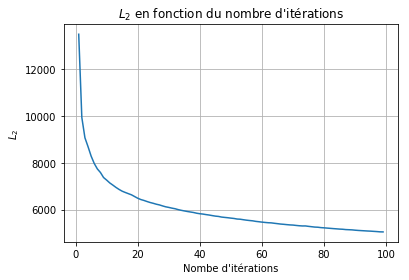

In [19]:
plt.plot(range(1,100), Loss_list)
plt.xlabel("Nombe d'itérations")
plt.ylabel("$L_2$")
plt.title("$L_2$ en fonction du nombre d'itérations")
plt.grid(True)
plt.show()

In [20]:
plt.plot(range(1,10), time_list)
plt.xlabel("Nombre de machines")
plt.ylabel("Temps d'exécution")
plt.title("Temps d'exécution en fonction du nombre de machines")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (1,)

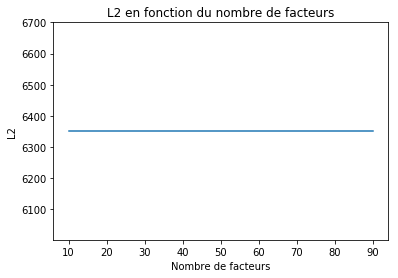

In [21]:
plt.plot(range(10,100,10), LossF_list)
plt.xlabel("Nombre de facteurs")
plt.ylabel("L2" )
plt.title("L2 en fonction du nombre de facteurs")
plt.show()

In [23]:
plt.plot(np.arange(0.1,0.9,0.1), LossBeta_list)
plt.xlabel("beta")
plt.ylabel("L2" )
plt.title("L2 en fonction de beta")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (8,) and (4,)